<a href="https://colab.research.google.com/github/DanielAmadeus29/ImageCaptioning/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

flickr8k Dataset Downloaded (Kaggle)

Verify File

ls -lah /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1

In [2]:
import kagglehub

path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:26<00:00, 41.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


Preprocess the Dataset
1. Extract image using CNN (inception V3)
2. Tokenize and encode captions
3. Prepare the data for training the LSTM decoder

In [3]:
ls -lah /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1

total 3.6M
drwxr-xr-x 3 root root 4.0K Mar 13 07:36 ./
drwxr-xr-x 3 root root 4.0K Mar 13 07:35 ../
-rw-r--r-- 1 root root 3.2M Mar 13 07:36 captions.txt
drwxr-xr-x 2 root root 404K Mar 13 07:36 Images/


In [4]:
mv /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1 /NLP

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout


print(os.listdir("/NLP"))

['captions.txt', 'Images']


1.2 Load Caption File

In [6]:
captions_path = "/NLP/captions.txt"
images_path = "/NLP/Images/"

df = pd.read_csv(captions_path)
print(df.head(4))



                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  


1.3 Creates DataFrame with two columns (image, caption)


In [ ]:
#Store imageID as keys, list of captions as Values
captions_dict = {}

# Open the "Captions" file.
# "r" is read mode
# split("\t") = separate caption and image
# parts[0] = imageId
# parts[1] = caption

with open(captions_path, "r") as file:

  for line in file:

    parts = line.strip().split(" ", 1)  # Ensure splitting happens only at the first space

    if len(parts) < 2: # Each line has at least 2 parts
      continue # skip lines that do not contain valid image-captiion pairs


    image_id, caption = parts
    #removes "#" in 1.jpg#0
    image_id = image_id.split("#")[0]

    if image_id not in captions_dict:

        captions_dict[image_id] = []
    captions_dict[image_id].append(caption)

captions_df = pd.DataFrame([(k, v) for k, captions in captions_dict.items() for v in captions], columns=["image", "caption"])

for img, caps in list(captions_dict.items())[:5]:
    print(f"Image: {img}, Captions: {caps}")

# for index, row in captions_df.head(5).iterrows():
#     print(f"Image: {row['image']}, Caption: {row['caption']}")



Image: 1000268201_693b08cb0e.jpg,A, Captions: ['child in a pink dress is climbing up a set of stairs in an entry way .', 'girl going into a wooden building .', 'little girl climbing into a wooden playhouse .', 'little girl climbing the stairs to her playhouse .', 'little girl in a pink dress going into a wooden cabin .']
Image: 1001773457_577c3a7d70.jpg,A, Captions: ['black dog and a spotted dog are fighting', 'black dog and a tri-colored dog playing with each other on the road .', 'black dog and a white dog with brown spots are staring at each other in the street .']
Image: 1001773457_577c3a7d70.jpg,Two, Captions: ['dogs of different breeds looking at each other on the road .', 'dogs on pavement moving toward each other .']
Image: 1002674143_1b742ab4b8.jpg,A, Captions: ['little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'little girl is sitting in front of a large painted rainbow .', 'small girl in the grass plays with fingerpaints in front of

THisss (Fixed Path FIle)

In [7]:
import os
import pandas as pd

captions_dict = {}

with open(captions_path, "r") as file:
    for line in file:
        line = line.strip()
        if not line:
            continue  # skip empty lines

        # Split on ".jpg," exactly once
        if ".jpg," in line:
            parts = line.split(".jpg,", 1)
            image_id = parts[0] + ".jpg"
            caption = parts[1].strip()
        else:
            parts = line.split(".jpg", 1)
            if len(parts) < 2:
                continue
            image_id = parts[0] + ".jpg"
            caption = parts[1].strip()

        # Add to dict
        if image_id not in captions_dict:
            captions_dict[image_id] = []
        captions_dict[image_id].append(caption)

# Build a DataFrame
captions_df = pd.DataFrame([(k, v) for k, captions in captions_dict.items() for v in captions], columns=["image", "caption"])

for img, caps in list(captions_dict.items())[:5]:
    print(f"Image: {img}, Captions: {caps}")

Image: 1000268201_693b08cb0e.jpg, Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
Image: 1001773457_577c3a7d70.jpg, Captions: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
Image: 1002674143_1b742ab4b8.jpg, Captions: ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a ra

**Step 2: Preprocess Images**

In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

for image_id in captions_dict.keys():
    base_name, _ = os.path.splitext(image_id)  # splits off .jpg
    corrected_image_id = base_name + '.jpg'
    img_path = os.path.join(images_path, corrected_image_id)

def preprocess_image(images_path, target_size=(224, 224)):
    image = cv2.imread(images_path)
    if image is None:
      print(f"could not find {images_path}")
      return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 500  # Normalize pixel values
    return image

# Process all images
image_data = {}
for image_id in tqdm(captions_dict.keys()):
    img_path = os.path.join(images_path, image_id)
    image_data[image_id] = preprocess_image(img_path)

# Convert to NumPy array
X_images = np.array(list(image_data.values()))




 13%|█▎        | 1020/8091 [00:04<00:31, 222.90it/s]


KeyboardInterrupt: 

THISSS ONEEE

Batch Image Processing (RAM cant handle too many datasets)


---


Total Runtime
*   CPU: 20 Minutes
*   GPU: 2.30 Minutes




In [8]:
import cv2
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model

def preprocess_image(img_path, target_size=(224, 224)):
    if not os.path.exists(img_path):
        print(f"Could not find {img_path}")
        return None
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to read image: {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, target_size)          # Resize to target size
    img = img / 255.0                           # Normalize pixel values to [0, 1]
    return img

# Batch Size
batch_size = 20

batch_images = []
batch_keys = []

# Stores Batch on List
processed_batches = []
keys = list(captions_dict.keys())

# 1. Preprocess images in batches
for idx, image_id in enumerate(tqdm(keys, desc="Preprocessing images")):
    base_name, _ = os.path.splitext(image_id)
    corrected_image_id = base_name + '.jpg'
    img_path = os.path.join(images_path, corrected_image_id)

    processed_image = preprocess_image(img_path)
    if processed_image is not None:
        batch_images.append(processed_image)
        batch_keys.append(corrected_image_id)

    # Storing Batch if full
    if (idx + 1) % batch_size == 0:
        X_images_batch = np.array(batch_images)
        print(f"Processed batch {int((idx + 1) / batch_size)}: shape {X_images_batch.shape}")
        processed_batches.append((batch_keys, X_images_batch))
        batch_images = []
        batch_keys = []

# Process any remaining images that didn't complete a full batch
if batch_images:
    X_images_batch = np.array(batch_images)
    print(f"Processed final batch: shape {X_images_batch.shape}")
    processed_batches.append((batch_keys, X_images_batch))

# Load ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet')

model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

features_dict = {}
total_batches = len(processed_batches)

# 2. Extract features for each batch
for i, (batch_keys, X_images_batch) in enumerate(processed_batches, start=1):
    # Convert images from [0,1] to [0,255]
    X_images = X_images_batch * 255.0
    # Apply ResNet50 preprocessing
    X_images = preprocess_input(X_images)

    # Extract features (features_batch shape will be (batch_size, 2048))
    features_batch = model.predict(X_images)

    # Map each image key to its corresponding feature vector
    for key, feature in zip(batch_keys, features_batch):
        features_dict[key] = feature

    percentage = (i / total_batches) * 100
    print(f"Extracted features for batch {i}/{total_batches} ({percentage:.2f}%)")

print(f"Extracted features for {len(features_dict)} images.")


Preprocessing images:   1%|          | 60/8091 [00:00<00:38, 209.78it/s]

Processed batch 1: shape (20, 224, 224, 3)
Processed batch 2: shape (20, 224, 224, 3)
Processed batch 3: shape (20, 224, 224, 3)


Preprocessing images:   1%|▏         | 112/8091 [00:00<00:33, 239.70it/s]

Processed batch 4: shape (20, 224, 224, 3)
Processed batch 5: shape (20, 224, 224, 3)
Processed batch 6: shape (20, 224, 224, 3)


Preprocessing images:   2%|▏         | 165/8091 [00:00<00:31, 248.34it/s]

Processed batch 7: shape (20, 224, 224, 3)
Processed batch 8: shape (20, 224, 224, 3)
Processed batch 9: shape (20, 224, 224, 3)


Preprocessing images:   3%|▎         | 249/8091 [00:01<00:29, 265.76it/s]

Processed batch 10: shape (20, 224, 224, 3)
Processed batch 11: shape (20, 224, 224, 3)
Processed batch 12: shape (20, 224, 224, 3)


Preprocessing images:   4%|▍         | 307/8091 [00:01<00:28, 273.28it/s]

Processed batch 13: shape (20, 224, 224, 3)
Processed batch 14: shape (20, 224, 224, 3)
Processed batch 15: shape (20, 224, 224, 3)


Preprocessing images:   4%|▍         | 362/8091 [00:01<00:30, 255.11it/s]

Processed batch 16: shape (20, 224, 224, 3)
Processed batch 17: shape (20, 224, 224, 3)
Processed batch 18: shape (20, 224, 224, 3)


Preprocessing images:   5%|▌         | 417/8091 [00:01<00:29, 258.08it/s]

Processed batch 19: shape (20, 224, 224, 3)
Processed batch 20: shape (20, 224, 224, 3)
Processed batch 21: shape (20, 224, 224, 3)


Preprocessing images:   6%|▌         | 473/8091 [00:01<00:28, 268.15it/s]

Processed batch 22: shape (20, 224, 224, 3)
Processed batch 23: shape (20, 224, 224, 3)
Processed batch 24: shape (20, 224, 224, 3)


Preprocessing images:   7%|▋         | 527/8091 [00:02<00:29, 259.25it/s]

Processed batch 25: shape (20, 224, 224, 3)
Processed batch 26: shape (20, 224, 224, 3)
Processed batch 27: shape (20, 224, 224, 3)


Preprocessing images:   8%|▊         | 611/8091 [00:02<00:28, 266.64it/s]

Processed batch 28: shape (20, 224, 224, 3)
Processed batch 29: shape (20, 224, 224, 3)
Processed batch 30: shape (20, 224, 224, 3)


Preprocessing images:   8%|▊         | 667/8091 [00:02<00:28, 263.74it/s]

Processed batch 31: shape (20, 224, 224, 3)
Processed batch 32: shape (20, 224, 224, 3)
Processed batch 33: shape (20, 224, 224, 3)


Preprocessing images:   9%|▉         | 723/8091 [00:02<00:27, 269.14it/s]

Processed batch 34: shape (20, 224, 224, 3)
Processed batch 35: shape (20, 224, 224, 3)
Processed batch 36: shape (20, 224, 224, 3)


Preprocessing images:  10%|▉         | 777/8091 [00:03<00:27, 262.50it/s]

Processed batch 37: shape (20, 224, 224, 3)
Processed batch 38: shape (20, 224, 224, 3)
Processed batch 39: shape (20, 224, 224, 3)


Preprocessing images:  10%|█         | 830/8091 [00:03<00:29, 247.12it/s]

Processed batch 40: shape (20, 224, 224, 3)
Processed batch 41: shape (20, 224, 224, 3)
Processed batch 42: shape (20, 224, 224, 3)


Preprocessing images:  11%|█▏        | 911/8091 [00:03<00:27, 256.63it/s]

Processed batch 43: shape (20, 224, 224, 3)
Processed batch 44: shape (20, 224, 224, 3)
Processed batch 45: shape (20, 224, 224, 3)


Preprocessing images:  12%|█▏        | 969/8091 [00:03<00:26, 264.80it/s]

Processed batch 46: shape (20, 224, 224, 3)
Processed batch 47: shape (20, 224, 224, 3)
Processed batch 48: shape (20, 224, 224, 3)


Preprocessing images:  13%|█▎        | 1027/8091 [00:04<00:26, 267.74it/s]

Processed batch 49: shape (20, 224, 224, 3)
Processed batch 50: shape (20, 224, 224, 3)
Processed batch 51: shape (20, 224, 224, 3)


Preprocessing images:  13%|█▎        | 1084/8091 [00:04<00:25, 271.20it/s]

Processed batch 52: shape (20, 224, 224, 3)
Processed batch 53: shape (20, 224, 224, 3)
Processed batch 54: shape (20, 224, 224, 3)


Preprocessing images:  14%|█▍        | 1142/8091 [00:04<00:25, 276.87it/s]

Processed batch 55: shape (20, 224, 224, 3)
Processed batch 56: shape (20, 224, 224, 3)
Processed batch 57: shape (20, 224, 224, 3)


Preprocessing images:  15%|█▍        | 1201/8091 [00:04<00:25, 270.44it/s]

Processed batch 58: shape (20, 224, 224, 3)
Processed batch 59: shape (20, 224, 224, 3)
Processed batch 60: shape (20, 224, 224, 3)


Preprocessing images:  16%|█▌        | 1261/8091 [00:04<00:24, 277.57it/s]

Processed batch 61: shape (20, 224, 224, 3)
Processed batch 62: shape (20, 224, 224, 3)
Processed batch 63: shape (20, 224, 224, 3)


Preprocessing images:  16%|█▋        | 1317/8091 [00:05<00:24, 276.32it/s]

Processed batch 64: shape (20, 224, 224, 3)
Processed batch 65: shape (20, 224, 224, 3)
Processed batch 66: shape (20, 224, 224, 3)


Preprocessing images:  17%|█▋        | 1377/8091 [00:05<00:23, 281.83it/s]

Processed batch 67: shape (20, 224, 224, 3)
Processed batch 68: shape (20, 224, 224, 3)
Processed batch 69: shape (20, 224, 224, 3)


Preprocessing images:  18%|█▊        | 1438/8091 [00:05<00:23, 288.19it/s]

Processed batch 70: shape (20, 224, 224, 3)
Processed batch 71: shape (20, 224, 224, 3)
Processed batch 72: shape (20, 224, 224, 3)


Preprocessing images:  18%|█▊        | 1496/8091 [00:05<00:23, 283.79it/s]

Processed batch 73: shape (20, 224, 224, 3)
Processed batch 74: shape (20, 224, 224, 3)
Processed batch 75: shape (20, 224, 224, 3)


Preprocessing images:  19%|█▉        | 1553/8091 [00:05<00:23, 272.74it/s]

Processed batch 76: shape (20, 224, 224, 3)
Processed batch 77: shape (20, 224, 224, 3)
Processed batch 78: shape (20, 224, 224, 3)


Preprocessing images:  20%|█▉        | 1609/8091 [00:06<00:24, 264.49it/s]

Processed batch 79: shape (20, 224, 224, 3)
Processed batch 80: shape (20, 224, 224, 3)
Processed batch 81: shape (20, 224, 224, 3)


Preprocessing images:  21%|██        | 1667/8091 [00:06<00:24, 259.99it/s]

Processed batch 82: shape (20, 224, 224, 3)
Processed batch 83: shape (20, 224, 224, 3)
Processed batch 84: shape (20, 224, 224, 3)


Preprocessing images:  22%|██▏       | 1750/8091 [00:06<00:24, 261.41it/s]

Processed batch 85: shape (20, 224, 224, 3)
Processed batch 86: shape (20, 224, 224, 3)
Processed batch 87: shape (20, 224, 224, 3)


Preprocessing images:  22%|██▏       | 1814/8091 [00:06<00:21, 287.91it/s]

Processed batch 88: shape (20, 224, 224, 3)
Processed batch 89: shape (20, 224, 224, 3)
Processed batch 90: shape (20, 224, 224, 3)
Processed batch 91: shape (20, 224, 224, 3)


Preprocessing images:  23%|██▎       | 1874/8091 [00:07<00:21, 288.48it/s]

Processed batch 92: shape (20, 224, 224, 3)
Processed batch 93: shape (20, 224, 224, 3)
Processed batch 94: shape (20, 224, 224, 3)


Preprocessing images:  24%|██▍       | 1932/8091 [00:07<00:21, 282.81it/s]

Processed batch 95: shape (20, 224, 224, 3)
Processed batch 96: shape (20, 224, 224, 3)
Processed batch 97: shape (20, 224, 224, 3)


Preprocessing images:  25%|██▍       | 1990/8091 [00:07<00:21, 277.44it/s]

Processed batch 98: shape (20, 224, 224, 3)
Processed batch 99: shape (20, 224, 224, 3)
Processed batch 100: shape (20, 224, 224, 3)


Preprocessing images:  25%|██▌       | 2048/8091 [00:07<00:24, 247.22it/s]

Processed batch 101: shape (20, 224, 224, 3)
Processed batch 102: shape (20, 224, 224, 3)
Processed batch 103: shape (20, 224, 224, 3)


Preprocessing images:  26%|██▌       | 2100/8091 [00:08<00:29, 204.18it/s]

Processed batch 104: shape (20, 224, 224, 3)
Processed batch 105: shape (20, 224, 224, 3)


Preprocessing images:  26%|██▋       | 2143/8091 [00:08<00:33, 178.41it/s]

Processed batch 106: shape (20, 224, 224, 3)
Processed batch 107: shape (20, 224, 224, 3)


Preprocessing images:  27%|██▋       | 2181/8091 [00:08<00:33, 175.28it/s]

Processed batch 108: shape (20, 224, 224, 3)
Processed batch 109: shape (20, 224, 224, 3)


Preprocessing images:  27%|██▋       | 2220/8091 [00:08<00:34, 172.43it/s]

Processed batch 110: shape (20, 224, 224, 3)
Processed batch 111: shape (20, 224, 224, 3)


Preprocessing images:  28%|██▊       | 2260/8091 [00:08<00:33, 172.49it/s]

Processed batch 112: shape (20, 224, 224, 3)
Processed batch 113: shape (20, 224, 224, 3)


Preprocessing images:  28%|██▊       | 2300/8091 [00:09<00:35, 162.14it/s]

Processed batch 114: shape (20, 224, 224, 3)
Processed batch 115: shape (20, 224, 224, 3)


Preprocessing images:  29%|██▉       | 2335/8091 [00:09<00:37, 155.28it/s]

Processed batch 116: shape (20, 224, 224, 3)
Processed batch 117: shape (20, 224, 224, 3)


Preprocessing images:  29%|██▉       | 2381/8091 [00:09<00:39, 145.85it/s]

Processed batch 118: shape (20, 224, 224, 3)
Processed batch 119: shape (20, 224, 224, 3)


Preprocessing images:  30%|██▉       | 2420/8091 [00:10<00:37, 152.96it/s]

Processed batch 120: shape (20, 224, 224, 3)
Processed batch 121: shape (20, 224, 224, 3)


Preprocessing images:  30%|███       | 2460/8091 [00:10<00:36, 156.31it/s]

Processed batch 122: shape (20, 224, 224, 3)
Processed batch 123: shape (20, 224, 224, 3)


Preprocessing images:  31%|███       | 2502/8091 [00:10<00:31, 179.22it/s]

Processed batch 124: shape (20, 224, 224, 3)
Processed batch 125: shape (20, 224, 224, 3)
Processed batch 126: shape (20, 224, 224, 3)


Preprocessing images:  32%|███▏      | 2569/8091 [00:10<00:27, 200.96it/s]

Processed batch 127: shape (20, 224, 224, 3)
Processed batch 128: shape (20, 224, 224, 3)


Preprocessing images:  32%|███▏      | 2614/8091 [00:11<00:26, 209.59it/s]

Processed batch 129: shape (20, 224, 224, 3)
Processed batch 130: shape (20, 224, 224, 3)
Processed batch 131: shape (20, 224, 224, 3)


Preprocessing images:  33%|███▎      | 2682/8091 [00:11<00:25, 213.04it/s]

Processed batch 132: shape (20, 224, 224, 3)
Processed batch 133: shape (20, 224, 224, 3)
Processed batch 134: shape (20, 224, 224, 3)


Preprocessing images:  34%|███▍      | 2731/8091 [00:11<00:23, 228.31it/s]

Processed batch 135: shape (20, 224, 224, 3)
Processed batch 136: shape (20, 224, 224, 3)
Processed batch 137: shape (20, 224, 224, 3)


Preprocessing images:  34%|███▍      | 2780/8091 [00:11<00:24, 215.28it/s]

Processed batch 138: shape (20, 224, 224, 3)
Processed batch 139: shape (20, 224, 224, 3)
Processed batch 140: shape (20, 224, 224, 3)


Preprocessing images:  35%|███▌      | 2845/8091 [00:12<00:25, 207.14it/s]

Processed batch 141: shape (20, 224, 224, 3)
Processed batch 142: shape (20, 224, 224, 3)
Processed batch 143: shape (20, 224, 224, 3)


Preprocessing images:  36%|███▌      | 2908/8091 [00:12<00:25, 205.26it/s]

Processed batch 144: shape (20, 224, 224, 3)
Processed batch 145: shape (20, 224, 224, 3)
Processed batch 146: shape (20, 224, 224, 3)


Preprocessing images:  37%|███▋      | 2975/8091 [00:12<00:24, 209.56it/s]

Processed batch 147: shape (20, 224, 224, 3)
Processed batch 148: shape (20, 224, 224, 3)
Processed batch 149: shape (20, 224, 224, 3)


Preprocessing images:  38%|███▊      | 3040/8091 [00:13<00:25, 202.02it/s]

Processed batch 150: shape (20, 224, 224, 3)
Processed batch 151: shape (20, 224, 224, 3)
Processed batch 152: shape (20, 224, 224, 3)


Preprocessing images:  38%|███▊      | 3085/8091 [00:13<00:23, 212.54it/s]

Processed batch 153: shape (20, 224, 224, 3)
Processed batch 154: shape (20, 224, 224, 3)
Processed batch 155: shape (20, 224, 224, 3)


Preprocessing images:  39%|███▉      | 3155/8091 [00:13<00:22, 223.29it/s]

Processed batch 156: shape (20, 224, 224, 3)
Processed batch 157: shape (20, 224, 224, 3)
Processed batch 158: shape (20, 224, 224, 3)


Preprocessing images:  40%|███▉      | 3202/8091 [00:13<00:22, 212.95it/s]

Processed batch 159: shape (20, 224, 224, 3)
Processed batch 160: shape (20, 224, 224, 3)
Processed batch 161: shape (20, 224, 224, 3)


Preprocessing images:  40%|████      | 3273/8091 [00:14<00:21, 219.22it/s]

Processed batch 162: shape (20, 224, 224, 3)
Processed batch 163: shape (20, 224, 224, 3)
Processed batch 164: shape (20, 224, 224, 3)


Preprocessing images:  41%|████▏     | 3345/8091 [00:14<00:21, 220.78it/s]

Processed batch 165: shape (20, 224, 224, 3)
Processed batch 166: shape (20, 224, 224, 3)
Processed batch 167: shape (20, 224, 224, 3)


Preprocessing images:  42%|████▏     | 3398/8091 [00:14<00:19, 239.11it/s]

Processed batch 168: shape (20, 224, 224, 3)
Processed batch 169: shape (20, 224, 224, 3)
Processed batch 170: shape (20, 224, 224, 3)


Preprocessing images:  43%|████▎     | 3448/8091 [00:14<00:21, 217.00it/s]

Processed batch 171: shape (20, 224, 224, 3)
Processed batch 172: shape (20, 224, 224, 3)
Processed batch 173: shape (20, 224, 224, 3)


Preprocessing images:  43%|████▎     | 3517/8091 [00:15<00:21, 217.76it/s]

Processed batch 174: shape (20, 224, 224, 3)
Processed batch 175: shape (20, 224, 224, 3)
Processed batch 176: shape (20, 224, 224, 3)


Preprocessing images:  44%|████▍     | 3540/8091 [00:15<00:22, 203.08it/s]

Processed batch 177: shape (20, 224, 224, 3)
Processed batch 178: shape (20, 224, 224, 3)


Preprocessing images:  45%|████▍     | 3601/8091 [00:15<00:26, 171.40it/s]

Processed batch 179: shape (20, 224, 224, 3)
Processed batch 180: shape (20, 224, 224, 3)
Processed batch 181: shape (20, 224, 224, 3)


Preprocessing images:  45%|████▌     | 3670/8091 [00:16<00:21, 202.65it/s]

Processed batch 182: shape (20, 224, 224, 3)
Processed batch 183: shape (20, 224, 224, 3)
Processed batch 184: shape (20, 224, 224, 3)


Preprocessing images:  46%|████▌     | 3734/8091 [00:16<00:25, 168.11it/s]

Processed batch 185: shape (20, 224, 224, 3)
Processed batch 186: shape (20, 224, 224, 3)
Processed batch 187: shape (20, 224, 224, 3)


Preprocessing images:  47%|████▋     | 3800/8091 [00:16<00:23, 185.53it/s]

Processed batch 188: shape (20, 224, 224, 3)
Processed batch 189: shape (20, 224, 224, 3)
Processed batch 190: shape (20, 224, 224, 3)


Preprocessing images:  48%|████▊     | 3845/8091 [00:17<00:21, 200.18it/s]

Processed batch 191: shape (20, 224, 224, 3)
Processed batch 192: shape (20, 224, 224, 3)
Processed batch 193: shape (20, 224, 224, 3)


Preprocessing images:  48%|████▊     | 3916/8091 [00:17<00:18, 223.72it/s]

Processed batch 194: shape (20, 224, 224, 3)
Processed batch 195: shape (20, 224, 224, 3)
Processed batch 196: shape (20, 224, 224, 3)


Preprocessing images:  49%|████▉     | 3965/8091 [00:17<00:18, 221.35it/s]

Processed batch 197: shape (20, 224, 224, 3)
Processed batch 198: shape (20, 224, 224, 3)
Processed batch 199: shape (20, 224, 224, 3)


Preprocessing images:  50%|████▉     | 4034/8091 [00:17<00:18, 223.02it/s]

Processed batch 200: shape (20, 224, 224, 3)
Processed batch 201: shape (20, 224, 224, 3)
Processed batch 202: shape (20, 224, 224, 3)


Preprocessing images:  51%|█████     | 4102/8091 [00:18<00:19, 207.25it/s]

Processed batch 203: shape (20, 224, 224, 3)
Processed batch 204: shape (20, 224, 224, 3)
Processed batch 205: shape (20, 224, 224, 3)


Preprocessing images:  51%|█████▏    | 4148/8091 [00:18<00:18, 214.55it/s]

Processed batch 206: shape (20, 224, 224, 3)
Processed batch 207: shape (20, 224, 224, 3)
Processed batch 208: shape (20, 224, 224, 3)


Preprocessing images:  52%|█████▏    | 4223/8091 [00:18<00:17, 219.03it/s]

Processed batch 209: shape (20, 224, 224, 3)
Processed batch 210: shape (20, 224, 224, 3)
Processed batch 211: shape (20, 224, 224, 3)


Preprocessing images:  53%|█████▎    | 4274/8091 [00:19<00:16, 227.39it/s]

Processed batch 212: shape (20, 224, 224, 3)
Processed batch 213: shape (20, 224, 224, 3)
Processed batch 214: shape (20, 224, 224, 3)


Preprocessing images:  54%|█████▎    | 4343/8091 [00:19<00:16, 222.61it/s]

Processed batch 215: shape (20, 224, 224, 3)
Processed batch 216: shape (20, 224, 224, 3)
Processed batch 217: shape (20, 224, 224, 3)


Preprocessing images:  54%|█████▍    | 4391/8091 [00:19<00:16, 223.78it/s]

Processed batch 218: shape (20, 224, 224, 3)
Processed batch 219: shape (20, 224, 224, 3)
Processed batch 220: shape (20, 224, 224, 3)


Preprocessing images:  55%|█████▌    | 4464/8091 [00:19<00:15, 227.37it/s]

Processed batch 221: shape (20, 224, 224, 3)
Processed batch 222: shape (20, 224, 224, 3)
Processed batch 223: shape (20, 224, 224, 3)


Preprocessing images:  56%|█████▌    | 4512/8091 [00:20<00:15, 230.32it/s]

Processed batch 224: shape (20, 224, 224, 3)
Processed batch 225: shape (20, 224, 224, 3)
Processed batch 226: shape (20, 224, 224, 3)


Preprocessing images:  56%|█████▋    | 4560/8091 [00:20<00:15, 223.81it/s]

Processed batch 227: shape (20, 224, 224, 3)
Processed batch 228: shape (20, 224, 224, 3)


Preprocessing images:  57%|█████▋    | 4604/8091 [00:20<00:18, 188.49it/s]

Processed batch 229: shape (20, 224, 224, 3)
Processed batch 230: shape (20, 224, 224, 3)


Preprocessing images:  57%|█████▋    | 4643/8091 [00:20<00:20, 171.61it/s]

Processed batch 231: shape (20, 224, 224, 3)
Processed batch 232: shape (20, 224, 224, 3)


Preprocessing images:  58%|█████▊    | 4680/8091 [00:21<00:21, 161.62it/s]

Processed batch 233: shape (20, 224, 224, 3)
Processed batch 234: shape (20, 224, 224, 3)


Preprocessing images:  58%|█████▊    | 4720/8091 [00:21<00:21, 158.56it/s]

Processed batch 235: shape (20, 224, 224, 3)
Processed batch 236: shape (20, 224, 224, 3)


Preprocessing images:  59%|█████▉    | 4761/8091 [00:21<00:19, 168.94it/s]

Processed batch 237: shape (20, 224, 224, 3)
Processed batch 238: shape (20, 224, 224, 3)


Preprocessing images:  59%|█████▉    | 4800/8091 [00:21<00:20, 163.38it/s]

Processed batch 239: shape (20, 224, 224, 3)
Processed batch 240: shape (20, 224, 224, 3)


Preprocessing images:  60%|█████▉    | 4842/8091 [00:22<00:20, 155.83it/s]

Processed batch 241: shape (20, 224, 224, 3)
Processed batch 242: shape (20, 224, 224, 3)


Preprocessing images:  60%|██████    | 4878/8091 [00:22<00:20, 154.63it/s]

Processed batch 243: shape (20, 224, 224, 3)
Processed batch 244: shape (20, 224, 224, 3)


Preprocessing images:  61%|██████    | 4925/8091 [00:22<00:22, 140.43it/s]

Processed batch 245: shape (20, 224, 224, 3)
Processed batch 246: shape (20, 224, 224, 3)


Preprocessing images:  61%|██████▏   | 4960/8091 [00:22<00:21, 146.90it/s]

Processed batch 247: shape (20, 224, 224, 3)
Processed batch 248: shape (20, 224, 224, 3)


Preprocessing images:  62%|██████▏   | 5011/8091 [00:23<00:15, 196.16it/s]

Processed batch 249: shape (20, 224, 224, 3)
Processed batch 250: shape (20, 224, 224, 3)
Processed batch 251: shape (20, 224, 224, 3)


Preprocessing images:  63%|██████▎   | 5085/8091 [00:23<00:13, 217.35it/s]

Processed batch 252: shape (20, 224, 224, 3)
Processed batch 253: shape (20, 224, 224, 3)
Processed batch 254: shape (20, 224, 224, 3)


Preprocessing images:  63%|██████▎   | 5133/8091 [00:23<00:13, 225.47it/s]

Processed batch 255: shape (20, 224, 224, 3)
Processed batch 256: shape (20, 224, 224, 3)
Processed batch 257: shape (20, 224, 224, 3)


Preprocessing images:  64%|██████▍   | 5184/8091 [00:23<00:12, 224.64it/s]

Processed batch 258: shape (20, 224, 224, 3)
Processed batch 259: shape (20, 224, 224, 3)
Processed batch 260: shape (20, 224, 224, 3)


Preprocessing images:  65%|██████▍   | 5253/8091 [00:24<00:12, 225.99it/s]

Processed batch 261: shape (20, 224, 224, 3)
Processed batch 262: shape (20, 224, 224, 3)
Processed batch 263: shape (20, 224, 224, 3)


Preprocessing images:  66%|██████▌   | 5300/8091 [00:24<00:13, 206.22it/s]

Processed batch 264: shape (20, 224, 224, 3)
Processed batch 265: shape (20, 224, 224, 3)
Processed batch 266: shape (20, 224, 224, 3)


Preprocessing images:  66%|██████▋   | 5380/8091 [00:24<00:12, 214.37it/s]

Processed batch 267: shape (20, 224, 224, 3)
Processed batch 268: shape (20, 224, 224, 3)
Processed batch 269: shape (20, 224, 224, 3)


Preprocessing images:  67%|██████▋   | 5427/8091 [00:24<00:12, 217.19it/s]

Processed batch 270: shape (20, 224, 224, 3)
Processed batch 271: shape (20, 224, 224, 3)
Processed batch 272: shape (20, 224, 224, 3)


Preprocessing images:  68%|██████▊   | 5494/8091 [00:25<00:12, 212.97it/s]

Processed batch 273: shape (20, 224, 224, 3)
Processed batch 274: shape (20, 224, 224, 3)
Processed batch 275: shape (20, 224, 224, 3)


Preprocessing images:  69%|██████▊   | 5559/8091 [00:25<00:12, 208.70it/s]

Processed batch 276: shape (20, 224, 224, 3)
Processed batch 277: shape (20, 224, 224, 3)
Processed batch 278: shape (20, 224, 224, 3)


Preprocessing images:  69%|██████▉   | 5601/8091 [00:25<00:12, 201.00it/s]

Processed batch 279: shape (20, 224, 224, 3)
Processed batch 280: shape (20, 224, 224, 3)
Processed batch 281: shape (20, 224, 224, 3)


Preprocessing images:  70%|███████   | 5675/8091 [00:26<00:10, 229.60it/s]

Processed batch 282: shape (20, 224, 224, 3)
Processed batch 283: shape (20, 224, 224, 3)
Processed batch 284: shape (20, 224, 224, 3)


Preprocessing images:  71%|███████   | 5723/8091 [00:26<00:10, 221.50it/s]

Processed batch 285: shape (20, 224, 224, 3)
Processed batch 286: shape (20, 224, 224, 3)


Preprocessing images:  71%|███████▏  | 5770/8091 [00:26<00:10, 221.38it/s]

Processed batch 287: shape (20, 224, 224, 3)
Processed batch 288: shape (20, 224, 224, 3)
Processed batch 289: shape (20, 224, 224, 3)


Preprocessing images:  72%|███████▏  | 5840/8091 [00:26<00:10, 205.98it/s]

Processed batch 290: shape (20, 224, 224, 3)
Processed batch 291: shape (20, 224, 224, 3)
Processed batch 292: shape (20, 224, 224, 3)


Preprocessing images:  73%|███████▎  | 5890/8091 [00:27<00:09, 224.16it/s]

Processed batch 293: shape (20, 224, 224, 3)
Processed batch 294: shape (20, 224, 224, 3)
Processed batch 295: shape (20, 224, 224, 3)


Preprocessing images:  74%|███████▎  | 5962/8091 [00:27<00:09, 218.55it/s]

Processed batch 296: shape (20, 224, 224, 3)
Processed batch 297: shape (20, 224, 224, 3)
Processed batch 298: shape (20, 224, 224, 3)


Preprocessing images:  74%|███████▍  | 6014/8091 [00:27<00:08, 238.17it/s]

Processed batch 299: shape (20, 224, 224, 3)
Processed batch 300: shape (20, 224, 224, 3)
Processed batch 301: shape (20, 224, 224, 3)


Preprocessing images:  75%|███████▍  | 6062/8091 [00:27<00:09, 210.45it/s]

Processed batch 302: shape (20, 224, 224, 3)
Processed batch 303: shape (20, 224, 224, 3)
Processed batch 304: shape (20, 224, 224, 3)


Preprocessing images:  76%|███████▌  | 6113/8091 [00:28<00:08, 230.78it/s]

Processed batch 305: shape (20, 224, 224, 3)
Processed batch 306: shape (20, 224, 224, 3)


Preprocessing images:  76%|███████▌  | 6158/8091 [00:28<00:14, 131.19it/s]

Processed batch 307: shape (20, 224, 224, 3)


Preprocessing images:  77%|███████▋  | 6198/8091 [00:28<00:12, 149.06it/s]

Processed batch 308: shape (20, 224, 224, 3)
Processed batch 309: shape (20, 224, 224, 3)
Processed batch 310: shape (20, 224, 224, 3)


Preprocessing images:  77%|███████▋  | 6267/8091 [00:29<00:09, 193.23it/s]

Processed batch 311: shape (20, 224, 224, 3)
Processed batch 312: shape (20, 224, 224, 3)
Processed batch 313: shape (20, 224, 224, 3)


Preprocessing images:  78%|███████▊  | 6312/8091 [00:29<00:08, 207.58it/s]

Processed batch 314: shape (20, 224, 224, 3)
Processed batch 315: shape (20, 224, 224, 3)
Processed batch 316: shape (20, 224, 224, 3)


Preprocessing images:  79%|███████▊  | 6360/8091 [00:29<00:08, 203.16it/s]

Processed batch 317: shape (20, 224, 224, 3)
Processed batch 318: shape (20, 224, 224, 3)
Processed batch 319: shape (20, 224, 224, 3)


Preprocessing images:  80%|███████▉  | 6437/8091 [00:29<00:07, 233.41it/s]

Processed batch 320: shape (20, 224, 224, 3)
Processed batch 321: shape (20, 224, 224, 3)
Processed batch 322: shape (20, 224, 224, 3)


Preprocessing images:  80%|████████  | 6487/8091 [00:30<00:07, 223.50it/s]

Processed batch 323: shape (20, 224, 224, 3)
Processed batch 324: shape (20, 224, 224, 3)
Processed batch 325: shape (20, 224, 224, 3)


Preprocessing images:  81%|████████  | 6564/8091 [00:30<00:06, 230.66it/s]

Processed batch 326: shape (20, 224, 224, 3)
Processed batch 327: shape (20, 224, 224, 3)
Processed batch 328: shape (20, 224, 224, 3)


Preprocessing images:  82%|████████▏ | 6615/8091 [00:30<00:06, 235.54it/s]

Processed batch 329: shape (20, 224, 224, 3)
Processed batch 330: shape (20, 224, 224, 3)
Processed batch 331: shape (20, 224, 224, 3)


Preprocessing images:  82%|████████▏ | 6665/8091 [00:30<00:06, 232.79it/s]

Processed batch 332: shape (20, 224, 224, 3)
Processed batch 333: shape (20, 224, 224, 3)
Processed batch 334: shape (20, 224, 224, 3)


Preprocessing images:  83%|████████▎ | 6740/8091 [00:31<00:05, 225.43it/s]

Processed batch 335: shape (20, 224, 224, 3)
Processed batch 336: shape (20, 224, 224, 3)
Processed batch 337: shape (20, 224, 224, 3)


Preprocessing images:  84%|████████▍ | 6787/8091 [00:31<00:05, 228.91it/s]

Processed batch 338: shape (20, 224, 224, 3)
Processed batch 339: shape (20, 224, 224, 3)
Processed batch 340: shape (20, 224, 224, 3)


Preprocessing images:  85%|████████▍ | 6859/8091 [00:31<00:05, 230.06it/s]

Processed batch 341: shape (20, 224, 224, 3)
Processed batch 342: shape (20, 224, 224, 3)
Processed batch 343: shape (20, 224, 224, 3)


Preprocessing images:  85%|████████▌ | 6908/8091 [00:31<00:05, 223.66it/s]

Processed batch 344: shape (20, 224, 224, 3)
Processed batch 345: shape (20, 224, 224, 3)
Processed batch 346: shape (20, 224, 224, 3)


Preprocessing images:  86%|████████▋ | 6979/8091 [00:32<00:04, 230.34it/s]

Processed batch 347: shape (20, 224, 224, 3)
Processed batch 348: shape (20, 224, 224, 3)
Processed batch 349: shape (20, 224, 224, 3)


Preprocessing images:  87%|████████▋ | 7024/8091 [00:32<00:05, 199.40it/s]

Processed batch 350: shape (20, 224, 224, 3)
Processed batch 351: shape (20, 224, 224, 3)


Preprocessing images:  87%|████████▋ | 7069/8091 [00:32<00:04, 210.93it/s]

Processed batch 352: shape (20, 224, 224, 3)
Processed batch 353: shape (20, 224, 224, 3)
Processed batch 354: shape (20, 224, 224, 3)


Preprocessing images:  88%|████████▊ | 7135/8091 [00:33<00:05, 190.39it/s]

Processed batch 355: shape (20, 224, 224, 3)
Processed batch 356: shape (20, 224, 224, 3)


Preprocessing images:  88%|████████▊ | 7155/8091 [00:33<00:05, 181.91it/s]

Processed batch 357: shape (20, 224, 224, 3)
Processed batch 358: shape (20, 224, 224, 3)


Preprocessing images:  89%|████████▉ | 7192/8091 [00:33<00:05, 162.85it/s]

Processed batch 359: shape (20, 224, 224, 3)
Processed batch 360: shape (20, 224, 224, 3)


Preprocessing images:  89%|████████▉ | 7240/8091 [00:33<00:05, 144.00it/s]

Processed batch 361: shape (20, 224, 224, 3)
Processed batch 362: shape (20, 224, 224, 3)


Preprocessing images:  90%|█████████ | 7288/8091 [00:34<00:05, 135.10it/s]

Processed batch 363: shape (20, 224, 224, 3)
Processed batch 364: shape (20, 224, 224, 3)


Preprocessing images:  90%|█████████ | 7320/8091 [00:34<00:05, 134.18it/s]

Processed batch 365: shape (20, 224, 224, 3)
Processed batch 366: shape (20, 224, 224, 3)


Preprocessing images:  91%|█████████ | 7361/8091 [00:34<00:05, 127.83it/s]

Processed batch 367: shape (20, 224, 224, 3)
Processed batch 368: shape (20, 224, 224, 3)


Preprocessing images:  91%|█████████▏| 7394/8091 [00:34<00:05, 129.13it/s]

Processed batch 369: shape (20, 224, 224, 3)
Processed batch 370: shape (20, 224, 224, 3)


Preprocessing images:  92%|█████████▏| 7440/8091 [00:35<00:05, 128.64it/s]

Processed batch 371: shape (20, 224, 224, 3)
Processed batch 372: shape (20, 224, 224, 3)


Preprocessing images:  93%|█████████▎| 7486/8091 [00:35<00:03, 174.79it/s]

Processed batch 373: shape (20, 224, 224, 3)
Processed batch 374: shape (20, 224, 224, 3)
Processed batch 375: shape (20, 224, 224, 3)


Preprocessing images:  93%|█████████▎| 7547/8091 [00:35<00:02, 189.61it/s]

Processed batch 376: shape (20, 224, 224, 3)
Processed batch 377: shape (20, 224, 224, 3)
Processed batch 378: shape (20, 224, 224, 3)


Preprocessing images:  94%|█████████▍| 7616/8091 [00:36<00:02, 214.83it/s]

Processed batch 379: shape (20, 224, 224, 3)
Processed batch 380: shape (20, 224, 224, 3)
Processed batch 381: shape (20, 224, 224, 3)


Preprocessing images:  95%|█████████▍| 7680/8091 [00:36<00:02, 197.57it/s]

Processed batch 382: shape (20, 224, 224, 3)
Processed batch 383: shape (20, 224, 224, 3)
Processed batch 384: shape (20, 224, 224, 3)


Preprocessing images:  96%|█████████▌| 7727/8091 [00:36<00:01, 209.25it/s]

Processed batch 385: shape (20, 224, 224, 3)
Processed batch 386: shape (20, 224, 224, 3)
Processed batch 387: shape (20, 224, 224, 3)


Preprocessing images:  96%|█████████▋| 7791/8091 [00:37<00:01, 203.82it/s]

Processed batch 388: shape (20, 224, 224, 3)
Processed batch 389: shape (20, 224, 224, 3)
Processed batch 390: shape (20, 224, 224, 3)


Preprocessing images:  97%|█████████▋| 7838/8091 [00:37<00:01, 218.27it/s]

Processed batch 391: shape (20, 224, 224, 3)
Processed batch 392: shape (20, 224, 224, 3)


Preprocessing images:  97%|█████████▋| 7878/8091 [00:37<00:01, 126.09it/s]

Processed batch 393: shape (20, 224, 224, 3)
Processed batch 394: shape (20, 224, 224, 3)


Preprocessing images:  98%|█████████▊| 7921/8091 [00:37<00:01, 153.02it/s]

Processed batch 395: shape (20, 224, 224, 3)
Processed batch 396: shape (20, 224, 224, 3)
Processed batch 397: shape (20, 224, 224, 3)


Preprocessing images:  99%|█████████▊| 7988/8091 [00:38<00:00, 175.25it/s]

Processed batch 398: shape (20, 224, 224, 3)
Processed batch 399: shape (20, 224, 224, 3)


Preprocessing images:  99%|█████████▉| 8030/8091 [00:38<00:00, 130.10it/s]

Processed batch 400: shape (20, 224, 224, 3)
Processed batch 401: shape (20, 224, 224, 3)
Processed batch 402: shape (20, 224, 224, 3)


Preprocessing images: 100%|██████████| 8091/8091 [00:39<00:00, 207.39it/s]


Processed batch 403: shape (20, 224, 224, 3)
Processed batch 404: shape (20, 224, 224, 3)
Processed final batch: shape (11, 224, 224, 3)
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Extracted features for batch 1/405 (0.25%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Extracted features for batch 2/405 (0.49%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Extracted features for batch 3/405 (0.74%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Extracted features for batch 4/405 (0.99%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Extracted features for batch 5/405 (1.23%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Extracted features for batch 6/405 (1.48%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Extracted features for batch 7/405 (1.73%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Extracted features for batch 8/405 (1.98%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Extracted features for batch 9/405 (2.22%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Extracted features for batch 10/405 

All Image Plot

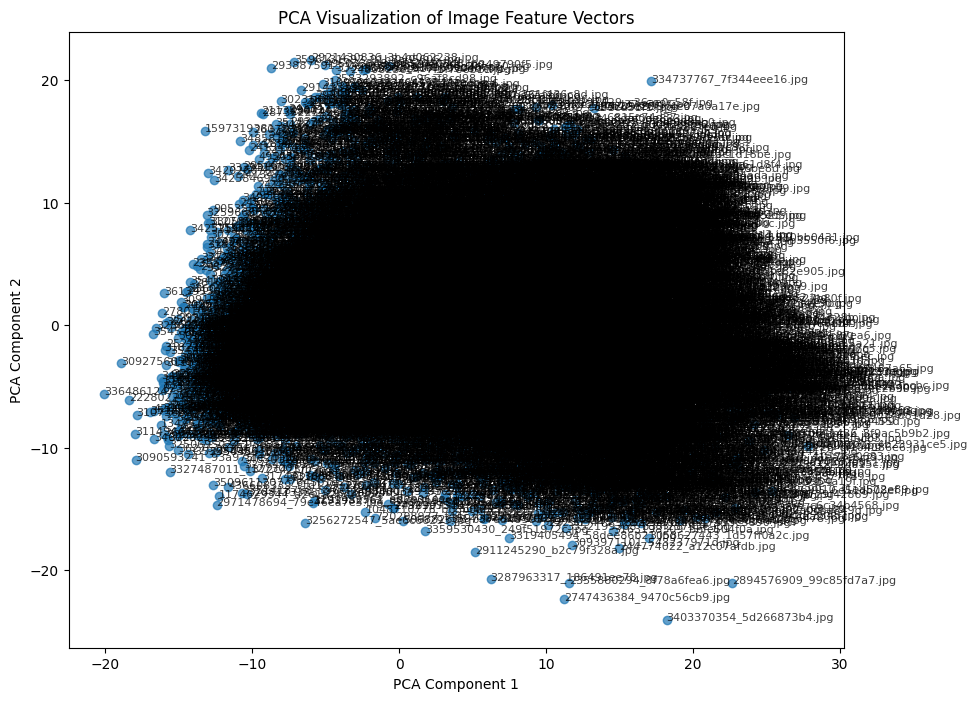

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Collect the real filenames (keys) and their feature vectors
keys = list(features_dict.keys())
features = np.array([features_dict[k] for k in keys])

# 2. Use PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# 3. Plot the 2D features
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.7)

# 4. Annotate points with the real filenames
for i, key in enumerate(keys):
    plt.annotate(key, (features_2d[i, 0], features_2d[i, 1]),
                 fontsize=8, alpha=0.75)

plt.title("PCA Visualization of Image Feature Vectors")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


Random Image Plot **(TESTING ONLY)**

Selected image paths:
/NLP/Images/3293018193_e4e0c8db7c.jpg
/NLP/Images/3448855727_f16dea7b03.jpg
/NLP/Images/397982550_cf9f5cdb74.jpg
/NLP/Images/3508882611_3947c0dbf5.jpg
/NLP/Images/3143982558_9e2d44c155.jpg
/NLP/Images/2800004913_c8394ba332.jpg
/NLP/Images/3442844140_15aa45e9b8.jpg
/NLP/Images/3527524436_a54aca78a9.jpg
/NLP/Images/3490517179_76dbd690de.jpg
/NLP/Images/2387197355_237f6f41ee.jpg
/NLP/Images/3640743904_d14eea0a0b.jpg
/NLP/Images/2249264723_d08655d9f2.jpg
/NLP/Images/2095007523_591f255708.jpg
/NLP/Images/3549277110_24d4064ccd.jpg
/NLP/Images/3455757720_7aeba57056.jpg
/NLP/Images/2782433864_5a0c311d87.jpg
/NLP/Images/3168123064_d1983b8f92.jpg
/NLP/Images/2515247156_c1b759fc33.jpg
/NLP/Images/2616561200_ea079f285a.jpg
/NLP/Images/1348947380_14f0fc1237.jpg


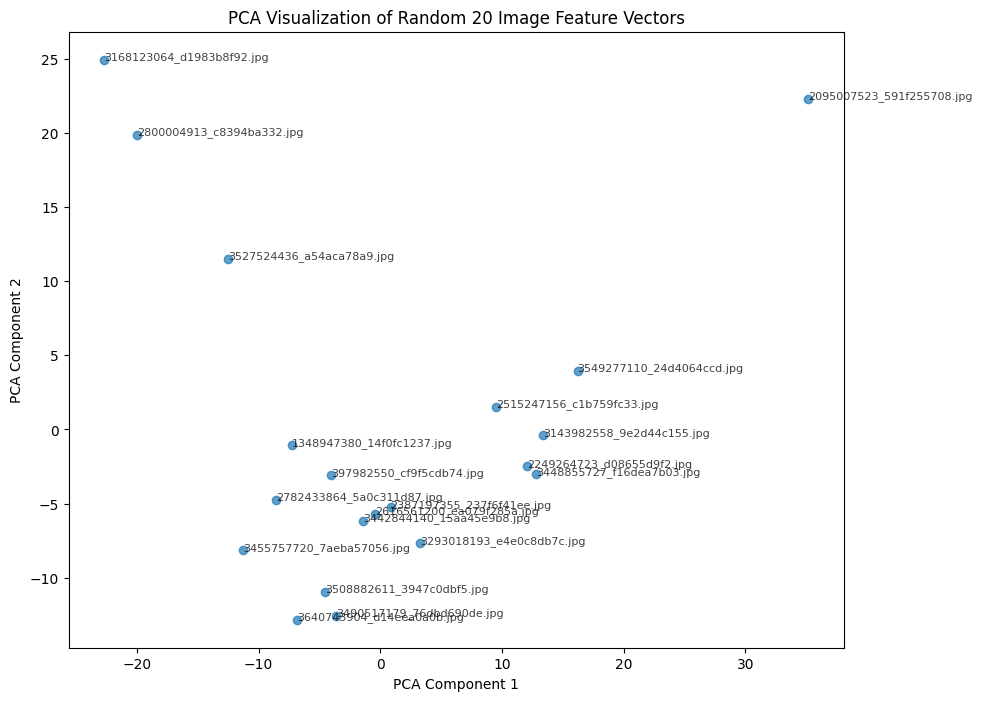

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import os

# Select 20 Image Random
all_keys = list(features_dict.keys())
selected_keys = random.sample(all_keys, 20)

# Print the full path for each selected image for your reference.
print("Selected image paths:")
for key in selected_keys:
    full_path = os.path.join(images_path, key)
    print(full_path)

# Collect the feature vectors for these selected keys
features = np.array([features_dict[k] for k in selected_keys])  # shape: (20, 2048)

# Use PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Plot the 2D features
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.7)

# Annotate points with the real filenames
for i, key in enumerate(selected_keys):
    plt.annotate(key, (features_2d[i, 0], features_2d[i, 1]),
                 fontsize=8, alpha=0.75)

plt.title("PCA Visualization of Random 20 Image Feature Vectors")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


Manually Compare Image from given plot to check simillarity **(TESTING ONLY)**


---


How?
1.   Cari plot yg deket dari randomize yg 20 gambar biar g pusing nyariny di yg full dataset
2.   Trs di atas gambar yg 20 random plot, ad file path yg bsa di copy biar gprlu ketik manual
3. Copy manual pathny ke code dibwh yg ad #HEREEE



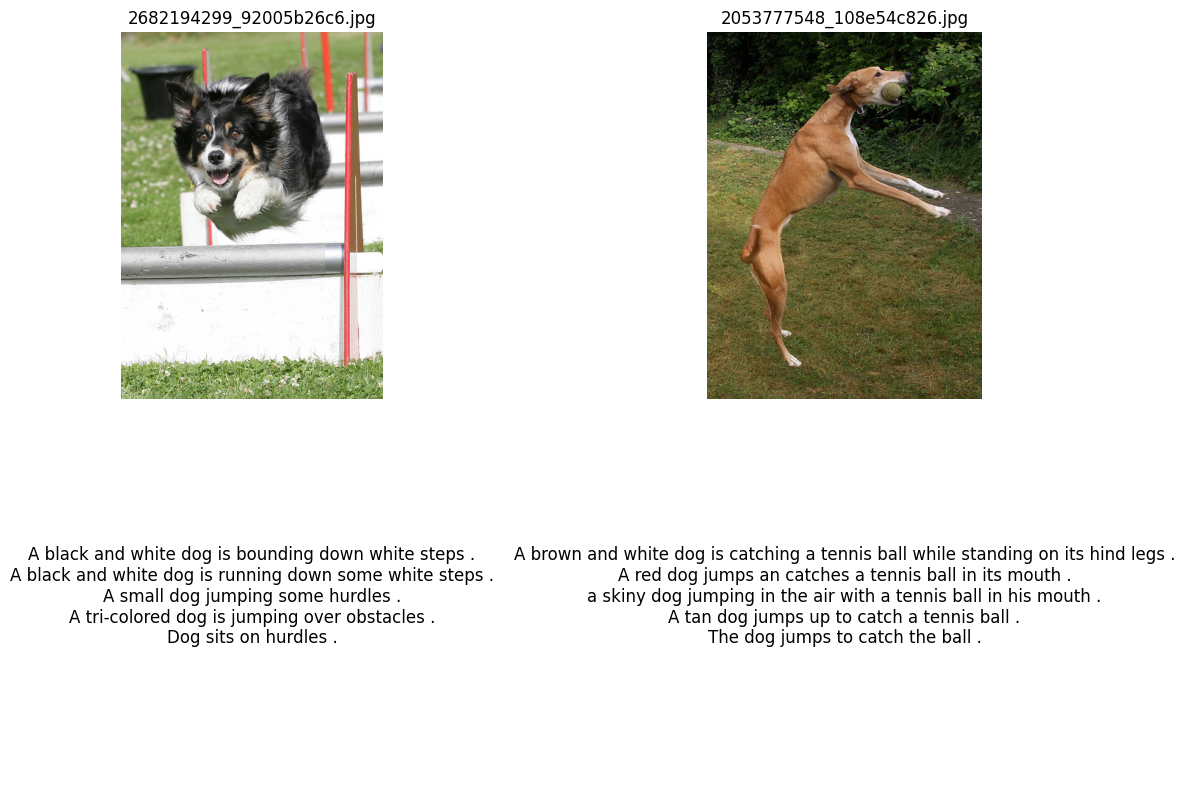

In [11]:
import os
import cv2
import matplotlib.pyplot as plt

# Define your image filenames (actual filenames from your dataset)
imageA = "2682194299_92005b26c6.jpg" #HEREEE Image1
imageB = "2053777548_108e54c826.jpg" #HEREEE Image2

imgA_path = os.path.join(images_path, imageA)
imgB_path = os.path.join(images_path, imageB)

# Load the images using cv2 and convert from BGR to RGB
imgA = cv2.imread(imgA_path)
imgB = cv2.imread(imgB_path)

if imgA is not None:
    imgA = cv2.cvtColor(imgA, cv2.COLOR_BGR2RGB)
else:
    print(f"Error loading {imgA_path}")
if imgB is not None:
    imgB = cv2.cvtColor(imgB, cv2.COLOR_BGR2RGB)
else:
    print(f"Error loading {imgB_path}")

# Retrieve captions from captions_dict
captions_A = captions_dict.get(imageA, [])
captions_B = captions_dict.get(imageB, [])

# Combine captions into a single string (each caption on a new line)
caption_A_text = "\n".join(captions_A) if captions_A else "No captions available."
caption_B_text = "\n".join(captions_B) if captions_B else "No captions available."

fig, axs = plt.subplots(2, 2, figsize=(12, 8))


axs[0, 0].imshow(imgA)
axs[0, 0].axis("off")
axs[0, 0].set_title(imageA)

axs[0, 1].imshow(imgB)
axs[0, 1].axis("off")
axs[0, 1].set_title(imageB)

axs[1, 0].text(0.5, 0.5, caption_A_text, horizontalalignment="center",
               verticalalignment="center", wrap=True, fontsize=12)
axs[1, 0].axis("off")

axs[1, 1].text(0.5, 0.5, caption_B_text, horizontalalignment="center",
               verticalalignment="center", wrap=True, fontsize=12)
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()


Text Processinggg !!! (Assignment 1!)
**Gausah di Run, ini cma buat yg Assigment 1.**

In [ ]:
import pandas as pd

# Convert your dict to a DataFrame
captions_df = pd.DataFrame(
    [(img, c) for img, cap_list in captions_dict.items() for c in cap_list],
    columns=["image", "caption"]
)

# Now captions_df is a DataFrame and supports .head()
for index, row in captions_df.head(5).iterrows():
    caption = row["caption"]
    tokens, stemmed, lemmatized = process_caption(caption)
    print(f"Image: {row['image']}")
    print("Original Caption:", caption)
    print("Tokenized:      ", tokens)
    print("Stemmed:        ", stemmed)
    print("Lemmatized:     ", lemmatized)
    print("-" * 80)


Image: 1000268201_693b08cb0e.jpg
Original Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Tokenized:       ['A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.']
Stemmed:         ['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climb', 'up', 'a', 'set', 'of', 'stair', 'in', 'an', 'entri', 'way', '.']
Lemmatized:      ['A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stair', 'in', 'an', 'entry', 'way', '.']
--------------------------------------------------------------------------------
Image: 1000268201_693b08cb0e.jpg
Original Caption: A girl going into a wooden building .
Tokenized:       ['A', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.']
Stemmed:         ['a', 'girl', 'go', 'into', 'a', 'wooden', 'build', '.']
Lemmatized:      ['A', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.']
------------------------------------------

Text Processing (THISS ONEEE)
- Cleaning text
- Tokenize
- Vocab

In [12]:
import pandas as pd
import re
import string
from collections import Counter

captions_df = pd.DataFrame(
    [(img, c) for img, cap_list in captions_dict.items() for c in cap_list],
    columns=["image", "caption"]
)
def clean_caption(caption):
    # Lowercase, remove punctuation and digits, then strip whitespace
    caption = caption.lower()
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    caption = re.sub(r'\d+', '', caption)
    return caption.strip()

def add_special_tokens(caption):
    return f"<start> {caption} <end>"

# Clean captions and add special tokens
captions_df["processed_caption"] = captions_df["caption"].apply(lambda x: add_special_tokens(clean_caption(x)))

# Tokenize captions and build vocabulary
all_tokens = []
for cap in captions_df["processed_caption"]:
    all_tokens.extend(cap.split())

word_counts = Counter(all_tokens)
min_freq = 1
vocab_words = [w for w, count in word_counts.items() if count >= min_freq]

# Include special tokens for padding and unknown words
vocab = ["<pad>", "<unk>"] + vocab_words
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Convert each processed caption into a list of indices
def caption_to_indices(caption):
    tokens = caption.split()
    return [word_to_idx.get(t, word_to_idx["<unk>"]) for t in tokens]

captions_df["indexed_caption"] = captions_df["processed_caption"].apply(caption_to_indices)

# Display
print(captions_df.head())


                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   

                                   processed_caption  \
0  <start> a child in a pink dress is climbing up...   
1  <start> a girl going into a wooden building <end>   
2  <start> a little girl climbing into a wooden p...   
3  <start> a little girl climbing the stairs to h...   
4  <start> a little girl in a pink dress going in...   

                                     indexed_caption  
0  [2, 3, 4, 5, 3, 6, 7, 8, 9, 10, 3, 11, 12, 13,...  
1                  [2, 

Only to Show Index Vocab
- Each Vocab has an Index

In [13]:
print(idx)
for idx, word in enumerate(vocab):
    print(f"{idx}: {word}")

8090
0: <pad>
1: <unk>
2: <start>
3: a
4: child
5: in
6: pink
7: dress
8: is
9: climbing
10: up
11: set
12: of
13: stairs
14: an
15: entry
16: way
17: <end>
18: girl
19: going
20: into
21: wooden
22: building
23: little
24: playhouse
25: the
26: to
27: her
28: cabin
29: black
30: dog
31: and
32: spotted
33: are
34: fighting
35: tricolored
36: playing
37: with
38: each
39: other
40: on
41: road
42: white
43: brown
44: spots
45: staring
46: at
47: street
48: two
49: dogs
50: different
51: breeds
52: looking
53: pavement
54: moving
55: toward
56: covered
57: paint
58: sits
59: front
60: painted
61: rainbow
62: hands
63: bowl
64: sitting
65: large
66: small
67: grass
68: plays
69: fingerpaints
70: canvas
71: it
72: there
73: pigtails
74: painting
75: young
76: outside
77: man
78: lays
79: bench
80: while
81: his
82: by
83: him
84: which
85: also
86: tied
87: sleeping
88: next
89: shirtless
90: lies
91: park
92: laying
93: holding
94: leash
95: ground
96: orange
97: hat
98: starring
99: som

Splitting Image to Train, Validation and Test

In [14]:
import random

all_images = list(captions_dict.keys())

random.seed(42)
random.shuffle(all_images)

# Split ratios
train_split = 0.8
val_split = 0.1
test_split = 0.1

num_images = len(all_images)
train_end = int(num_images * train_split)
val_end = train_end + int(num_images * val_split)

train_images = all_images[:train_end]
val_images = all_images[train_end:val_end]
test_images = all_images[val_end:]

print(f"Train images: {len(train_images)}, Validation images: {len(val_images)}, Test images: {len(test_images)}")


Train images: 6472, Validation images: 809, Test images: 810


FOR TESTINGGGG ONLYY !!! (👁️👄👁️)
- Randomize Image
- Compare Original Image and Processed Image
- Show caption with each vocabulary index

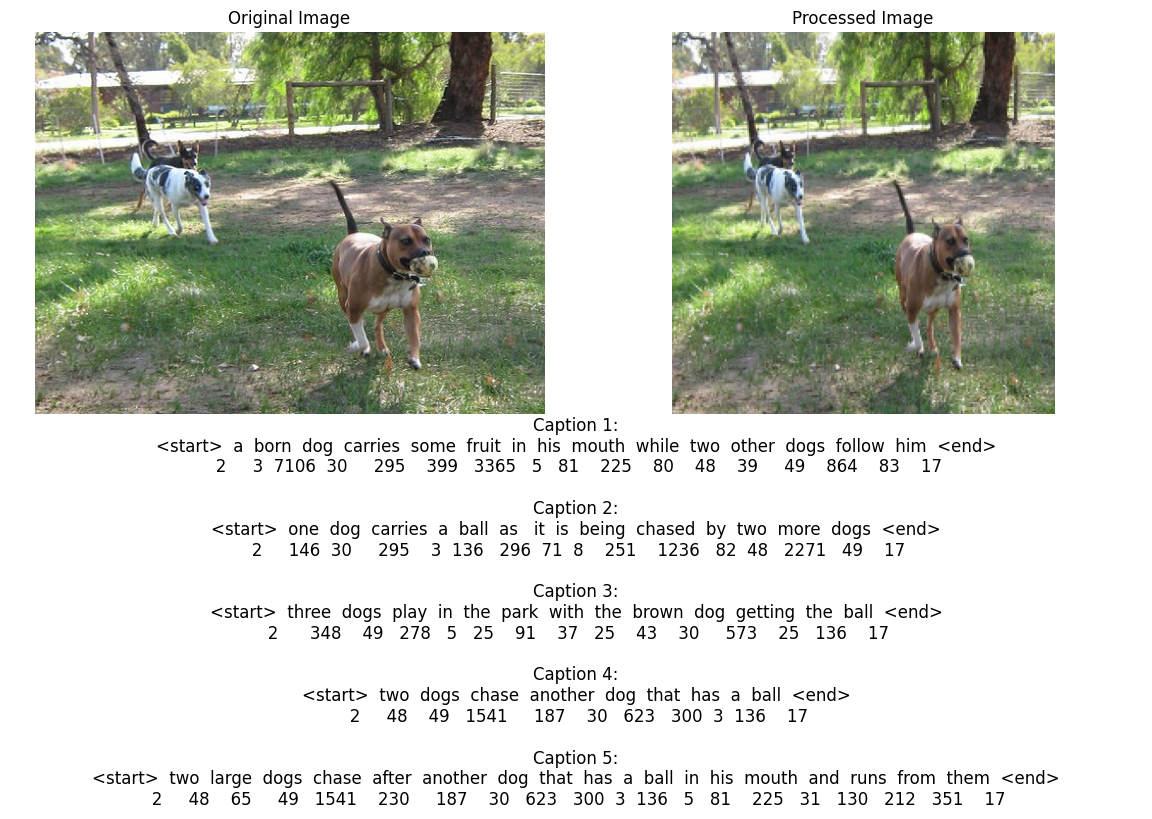

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
import random

def align_words_indices(words, indices):
    pairs = list(zip(words, indices))
    col_widths = [max(len(w), len(idx)) for w, idx in pairs]
    top_line = "  ".join(f"{w:^{cw}}" for (w, _), cw in zip(pairs, col_widths))
    bottom_line = "  ".join(f"{idx:^{cw}}" for (_, idx), cw in zip(pairs, col_widths))

    return top_line + "\n" + bottom_line

if processed_batches:
    # Random Pick Batch
    batch_keys, batch_array = random.choice(processed_batches)
    random_index = random.randint(0, len(batch_keys) - 1)
    key = batch_keys[random_index]
    proc_img = batch_array[random_index]

    # Load the original image
    orig_path = os.path.join(images_path, key)
    orig_img = cv2.imread(orig_path)
    if orig_img is not None:
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    else:
        print(f"Error loading original image: {orig_path}")
        orig_img = None

    # ALL captions for this image
    captions_for_image = captions_dict.get(key, [])
    if not captions_for_image:
        combined_text = "No caption available."
    else:
        combined_texts = []
        for idx, raw_cap in enumerate(captions_for_image, start=1):

            processed_caption = add_special_tokens(clean_caption(raw_cap))

            # Split into words and get corresponding indices
            words = processed_caption.split()
            indices = [str(word_to_idx.get(w, word_to_idx["<unk>"])) for w in words]

            aligned_str = align_words_indices(words, indices)

            caption_block = f"Caption {idx}:\n{aligned_str}"
            combined_texts.append(caption_block)

        # Join all captions with a blank line
        combined_text = "\n\n".join(combined_texts)

    # Plot
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[4, 1])

    # Original image
    ax_orig = fig.add_subplot(gs[0, 0])
    if orig_img is not None:
        ax_orig.imshow(orig_img)
    ax_orig.set_title("Original Image")
    ax_orig.axis("off")

    # Processed image
    ax_proc = fig.add_subplot(gs[0, 1])
    ax_proc.imshow(proc_img)
    ax_proc.set_title("Processed Image")
    ax_proc.axis("off")

    # Caption text
    ax_caption = fig.add_subplot(gs[1, :])
    ax_caption.axis("off")
    ax_caption.text(
        0.5, 1,
        combined_text,
        horizontalalignment="center",
        verticalalignment="center",
        wrap=True,
        fontsize=12
    )

    plt.tight_layout()
    plt.show()

else:
    print("No processed batches found.")





---

